In [144]:
%load_ext autoreload
%autoreload 2

import time

import matplotlib.pyplot as plt
import torch
from torch import nn

from tbfm import tbfm
from tbfm import test


BATCH_SIZE = 2500
RUNWAY_LENGTH = 20
TRIAL_LENGTH = 184
NUM_CHANNELS = 3
TRAIN_SET_SIZE = 1750

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# This generates some demo data using an Ornstein-Uhlenbeck process
# OUPs have been used to model various neuron-level phenomena such as synaptic inputs and firing rates, making
data = torch.zeros(BATCH_SIZE, TRIAL_LENGTH, NUM_CHANNELS).to(DEVICE)
for cidx in range(NUM_CHANNELS):
    channel_data = test.generate_ou_sinusoidal_moving_mean(
        trial_len=TRIAL_LENGTH,
        batch_size=BATCH_SIZE,
        phase_shift=15*cidx,
    ).squeeze()
    data[:, :, cidx] = channel_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


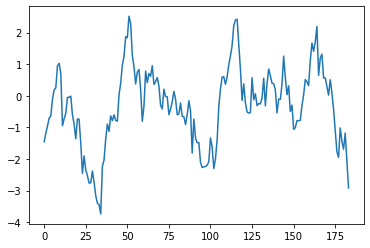

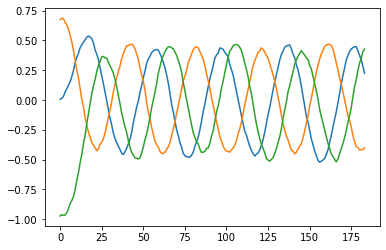

In [147]:
# This is what a single channel, single trial looks like
plt.plot(data[0, :, 0].to("cpu"))
plt.show()

# And some channel means across all trials
plt.plot(torch.mean(data[:, :, 0], axis=0).to("cpu"))
plt.plot(torch.mean(data[:, :, 1], axis=0).to("cpu"))
plt.plot(torch.mean(data[:, :, 2], axis=0).to("cpu"))
plt.show()

In [148]:
# Now we chunk the data up into the runway (x) versus predicted portion (y)
runways = data[:, :RUNWAY_LENGTH, :]
y = data[:, RUNWAY_LENGTH:, :]

# Then make a train versus test set
runways_train = runways[:TRAIN_SET_SIZE, :, :]
y_train = y[:TRAIN_SET_SIZE, :, :]
runways_test = runways[TRAIN_SET_SIZE:, :, :]
y_test = y[TRAIN_SET_SIZE:, :, :]

# We aren't stimulating, so let's make some null stimulation descriptors
STIM_DESC_DIM = 3
stim_desc = torch.zeros(1, TRIAL_LENGTH, STIM_DESC_DIM)
stim_desc[0, :, 0] = torch.arange(TRIAL_LENGTH) / TRIAL_LENGTH
stim_desc = stim_desc[:, RUNWAY_LENGTH:, :].to(DEVICE)

stim_desc_train = stim_desc.repeat(runways_train.shape[0], 1, 1)
stim_desc_test = stim_desc.repeat(runways_test.shape[0], 1, 1)

In [149]:
# Let's make a temporal basis function model which forecasts our multidimensional time series.
# This is a tiny problem; we don't need anything complex here.
NUM_BASES = 5
LATENT_DIM = 2
BASIS_DEPTH = 2
# Regularizer weight
LAMBDA = 0.05

model = tbfm.TBFM(NUM_CHANNELS, STIM_DESC_DIM, RUNWAY_LENGTH, NUM_BASES, TRIAL_LENGTH-RUNWAY_LENGTH,
                  batchy=y_train,
                  latent_dim=LATENT_DIM,
                  basis_depth=BASIS_DEPTH,
                  device=DEVICE)
optim = model.get_optim(lr=2e-4)

# Now z score our y values using the comming means/stdevs from the training set.
# Runways are z scored by the model on the fly, and y_hats will be in that z-scored space
y_train = model.zscore(y_train)
y_test = model.zscore(y_test)

In [150]:
# Cleared for takeoff! Let's train it...

NUM_EPOCHS = 10000
TEST_EPOCH_INTERVAL = 1000  # We will run against the test set every so often to monitor progress

losses_train = []
losses_test = []

start_time = time.time()
for eidx in range(NUM_EPOCHS):
    optim.zero_grad()
    
    yhat_train = model(runways_train, stim_desc_train)
    
    loss = nn.MSELoss()(yhat_train, y_train) 
    l1w = model.get_weighting_reg()
    (loss + LAMBDA * l1w).backward()
          
    losses_train.append((eidx, loss.item()))
    optim.step()
    
    if (eidx % TEST_EPOCH_INTERVAL) == 0:        
        with torch.no_grad():
            yhat_test = model(runways_test, stim_desc_test)
    
            loss = nn.MSELoss()(yhat_test, y_test)
            losses_test.append((eidx, loss.item()))
            
        print(f"epoch: {eidx}, train loss: {losses_train[-1][1]}, test loss: {losses_test[-1][1]}")

print(f"Training time: {time.time() - start_time}")

epoch: 0, train loss: 2.16369366645813, test loss: 2.1481287479400635
epoch: 1000, train loss: 1.0559602975845337, test loss: 1.0846524238586426
epoch: 2000, train loss: 0.9505630135536194, test loss: 0.9806217551231384
epoch: 3000, train loss: 0.9181749224662781, test loss: 0.9494242668151855
epoch: 4000, train loss: 0.9074089527130127, test loss: 0.9390423893928528
epoch: 5000, train loss: 0.9032378792762756, test loss: 0.9348819255828857
epoch: 6000, train loss: 0.9012594223022461, test loss: 0.9329488277435303
epoch: 7000, train loss: 0.9002014994621277, test loss: 0.9321550726890564
epoch: 8000, train loss: 0.8993225693702698, test loss: 0.9318463802337646
epoch: 9000, train loss: 0.8984645009040833, test loss: 0.9317792057991028
Training time: 19.71368956565857


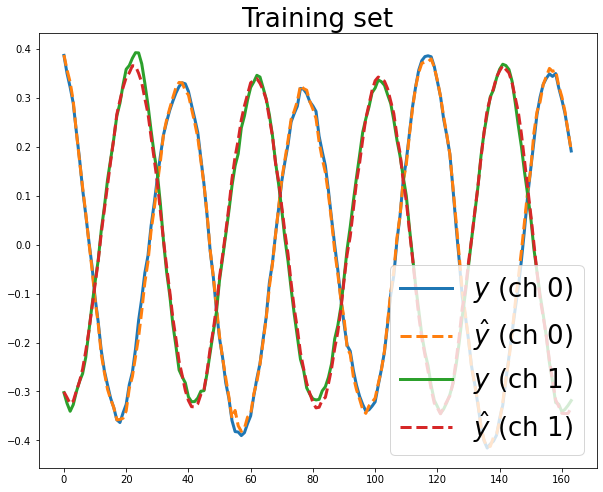

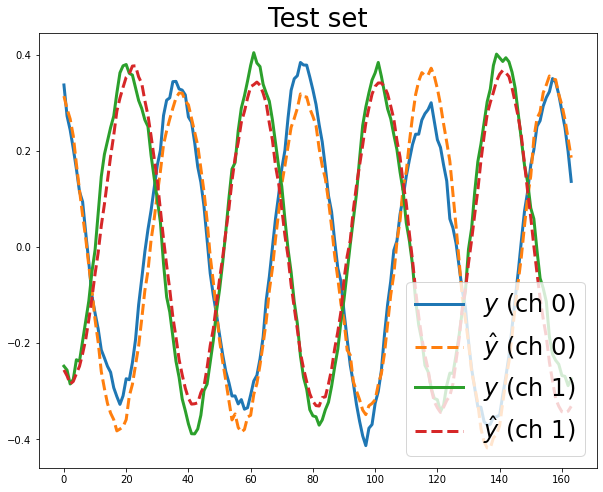

In [151]:
# Let's graph the latest set of predictions versus groundtruth for some channels

def graph_preds(y, yhat, ch):
    plt.plot(torch.mean(y[:, :, ch], axis=0).detach().cpu(), label="$y$ (ch %d)" % ch, linewidth=3.0)
    plt.plot(torch.mean(yhat[:, :, ch], axis=0).detach().cpu(), "--", label="$\hat{y}$ (ch %d)" % ch, linewidth=3.0)

plt.figure(figsize=(10, 8))
graph_preds(y_train, yhat_train, 0)
graph_preds(y_train, yhat_train, 1)
plt.legend(loc="lower right", fontsize=26)
plt.title("Training set", fontsize=26)
plt.show()

plt.figure(figsize=(10, 8))
graph_preds(y_test, yhat_test, 0)
graph_preds(y_test, yhat_test, 1)
plt.legend(loc="lower right", fontsize=24)
plt.title("Test set", fontsize=26)
plt.show()

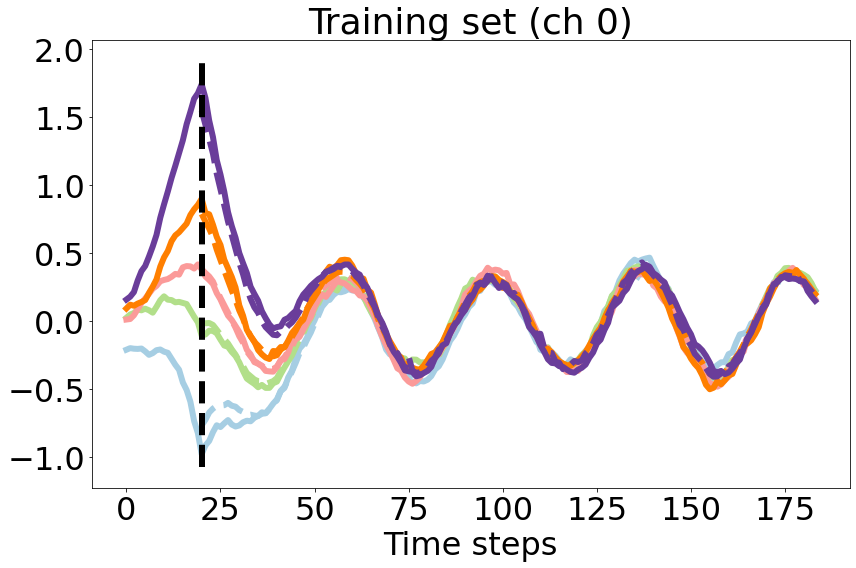

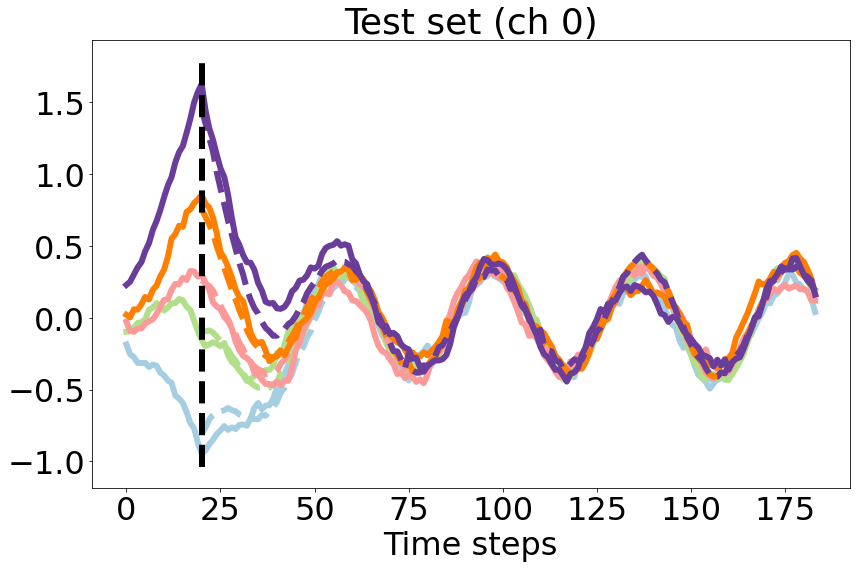

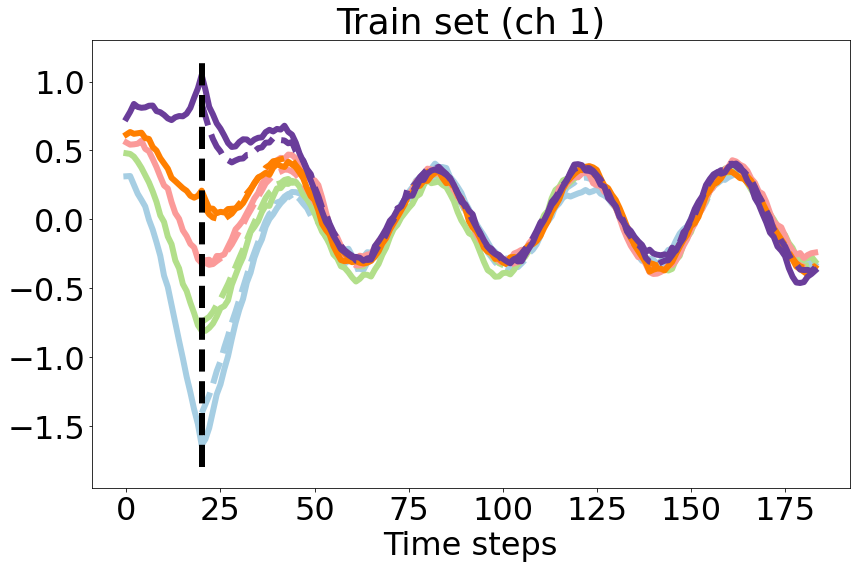

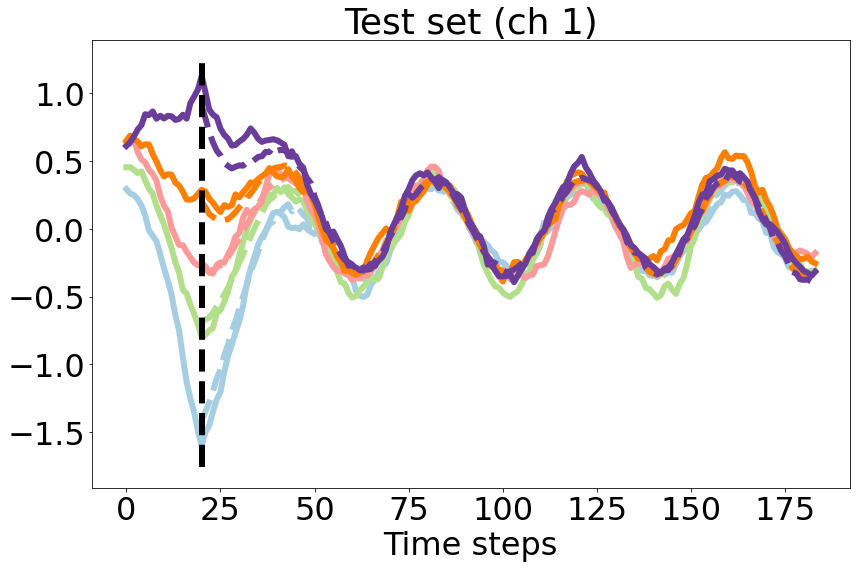

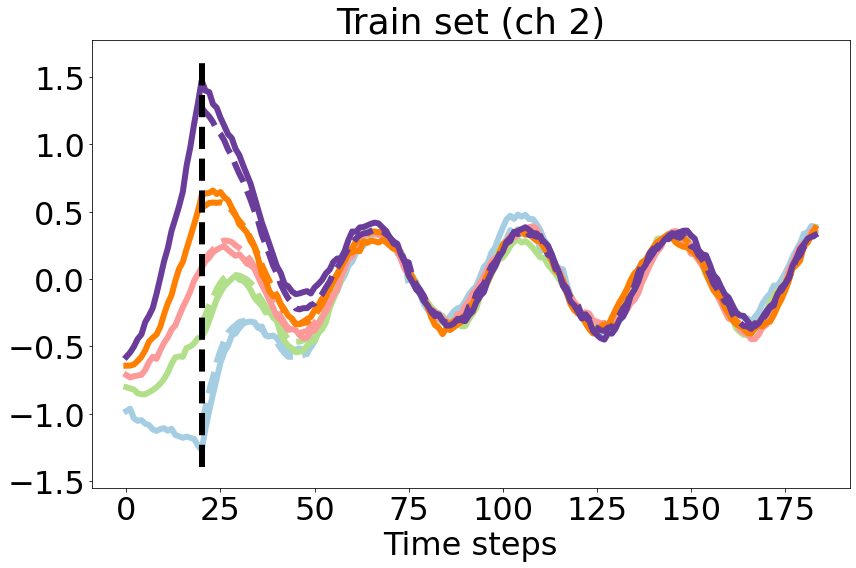

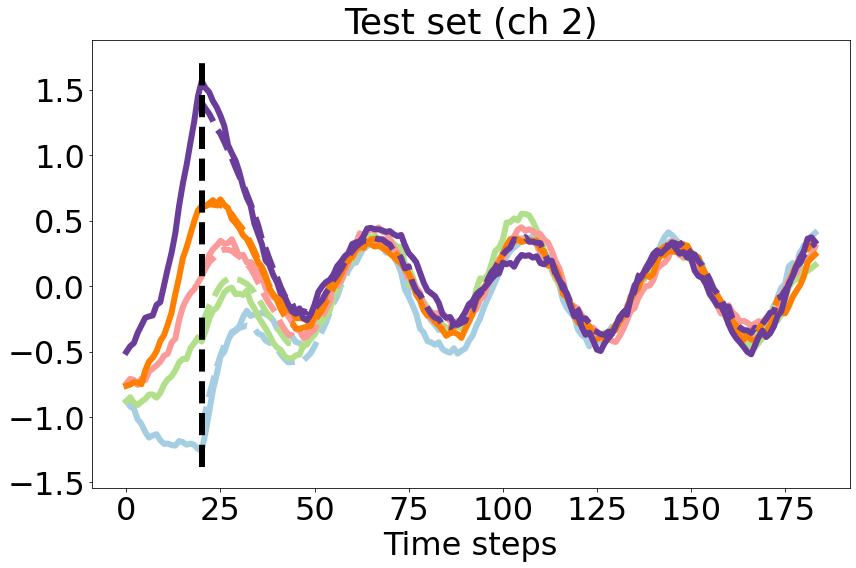

In [162]:
# Now to understand the state dependence of the predictions let's graph the mean predictions as a function of a
#   discretized state, versus groundtruth.

# We discretize the state at t=RUNWAY_LENGTH into bins, and show the mean prediction and
#   mean groundtruth for each bin. The bins are constructed using percentiles so we have
#   an equal number of trials in each.

# This is a complex graphing function so we outsource the logic to test.graph_state_dependency;
#   see details there.

bin_count = 5
full_y_train = model.zscore(data[:TRAIN_SET_SIZE, :, :].to(DEVICE))
test.graph_state_dependency(full_y_train, yhat_train, ch=0, runway_length=RUNWAY_LENGTH,
                            bin_count=bin_count, title="Training set (ch 0)")

full_y_test = model.zscore(data[TRAIN_SET_SIZE:, :, :].to(DEVICE))
test.graph_state_dependency(full_y_test, yhat_test, ch=0, runway_length=RUNWAY_LENGTH,
                            bin_count=bin_count, title="Test set (ch 0)")


test.graph_state_dependency(full_y_train, yhat_train, ch=1, runway_length=RUNWAY_LENGTH,
                            bin_count=bin_count, title="Train set (ch 1)")
test.graph_state_dependency(full_y_test, yhat_test, ch=1, runway_length=RUNWAY_LENGTH,
                            bin_count=bin_count, title="Test set (ch 1)")

test.graph_state_dependency(full_y_train, yhat_train, ch=2, runway_length=RUNWAY_LENGTH,
                            bin_count=bin_count, title="Train set (ch 2)")
test.graph_state_dependency(full_y_test, yhat_test, ch=2, runway_length=RUNWAY_LENGTH,
                            bin_count=bin_count, title="Test set (ch 2)")

# We see the TBFM captures the essential features of the state dependence across all channels, for both
#  the training and test sets.